# **Projeto DATASUS**

## DESAFIO
- Coletar da Base de Dados do DATASUS, de 2008 a 2024, e processar dados demográficos e de históricos de internações, recursos aplicados e óbitos hospitalares nos municípios brasileiros;
- Desenvolver modelos de redes neurais para identificar padrões e prever a evolução das taxas de óbito em cada município;
- Evidenciar as recomendações e avaliações sobre a alocação de recursos e estratégias de saúde pública hospitalar.


## **Importação das Bibliotecas**

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

## **PRÉ-PROCESSAMENTO DOS DADOS**


In [2]:
base_folder = 'data'
output_subfolder = 'dataset'
output_folder = os.path.join(base_folder, output_subfolder)

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Lista para armazenar todos os dataframes
dfs = []

for year_folder in os.listdir(base_folder):
    if year_folder.isdigit() and 2022 <= int(year_folder) <= 2024:
        year_path = os.path.join(base_folder, year_folder)
        files = [f for f in os.listdir(year_path) if f.endswith('.csv')]
        for file in files:
            # Carregar o dataframe, pulando a primeira linha
            df = pd.read_csv(os.path.join(year_path, file),
                             skiprows=1, delimiter=';')
            month = file.split('_')[-1].replace('.csv', '')
            df['Ano'] = int(year_folder)
            df['Mês'] = int(month) 
            dfs.append(df)
# Concatenar todos os dataframes
dados_unificados = pd.concat(dfs, ignore_index=True)
dados_unificados= dados_unificados.apply(lambda x: x.str.replace(',','.') if x.dtype == "object" else x)
dados_unificados.replace('-', 0, inplace=True)
for col in dados_unificados.columns:
    if col != 'Município':
        dados_unificados[col] = pd.to_numeric(dados_unificados[col])
dados_unificados.head(5)


,Município,AIH_aprovadas,Internações,Valor_total,Valor_serviços_hospitalares,Val_serv_hosp_-_compl_federal,Val_serv_hosp_-_compl_gestor,Valor_serviços_profissionais,Val_serv_prof_-_compl_federal,Val_serv_prof_-_compl_gestor,Valor_médio_AIH,Valor_médio_intern,Dias_permanência,Média_permanência,Óbitos,Taxa_mortalidade,Ano,Mês
0,110001 ALTA FLORESTA D'OESTE,121,121,47846.93,40674.35,0.00,0.0,7172.58,0.00,0.0,395.43,395.43,318,2.6,2,1.65,2022,1
1,110002 ARIQUEMES,467,467,803170.75,659092.55,8969.02,0.0,129632.74,5476.44,0.0,1719.85,1719.85,1439,3.1,29,6.21,2022,1
2,110003 CABIXI,8,8,4300.51,3690.77,0.00,0.0,609.74,0.00,0.0,537.56,537.56,19,2.4,0,0.00,2022,1
3,110004 CACOAL,1030,1030,926136.69,752367.29,0.00,0.0,173769.40,0.00,0.0,899.16,899.16,5399,5.2,49,4.76,2022,1
4,110005 CEREJEIRAS,79,79,35556.47,30659.17,0.00,0.0,4897.30,0.00,0.0,450.08,450.08,270,3.4,1,1.27,2022,1


In [3]:
# Salvar o DataFrame em um arquivo CSV
output_path = os.path.join(output_folder, 'dados1_2022-2024.csv')
dados_unificados.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f'Dados salvos em: {output_path}')

Dados salvos em: data\dataset\dados1_2022-2024.csv


In [4]:
# Verificar dados faltantes
pd.options.display.float_format = lambda x: f'{x}'
print(f'\ndescrição do dataset:\n{dados_unificados.describe()}')

print(f'\nNúmero de valores nulos:\n{dados_unificados.isnull().sum()}\n')
print(dados_unificados.dtypes)



descrição do dataset:
           AIH_aprovadas        Internações        Valor_total  \
count            92446.0            92446.0            92446.0   
mean  367.21531488652835    363.30136512126  574315.6562749065   
std   1682.9695437106636 1664.1966425309479 3500628.4556672117   
min                  1.0                1.0              44.22   
25%                 28.0               28.0           11492.02   
50%                 79.0               79.0          36625.045   
75%                229.0              228.0         148942.585   
max              63179.0            62522.0       136732480.52   

       Valor_serviços_hospitalares  Val_serv_hosp_-_compl_federal  \
count                      92446.0                        92446.0   
mean             452161.2520374056             5538.3845836488335   
std             2768535.8267686362              67201.42923271004   
min                          33.34                            0.0   
25%                       9511.745   

## **CORRELAÇÃO** 

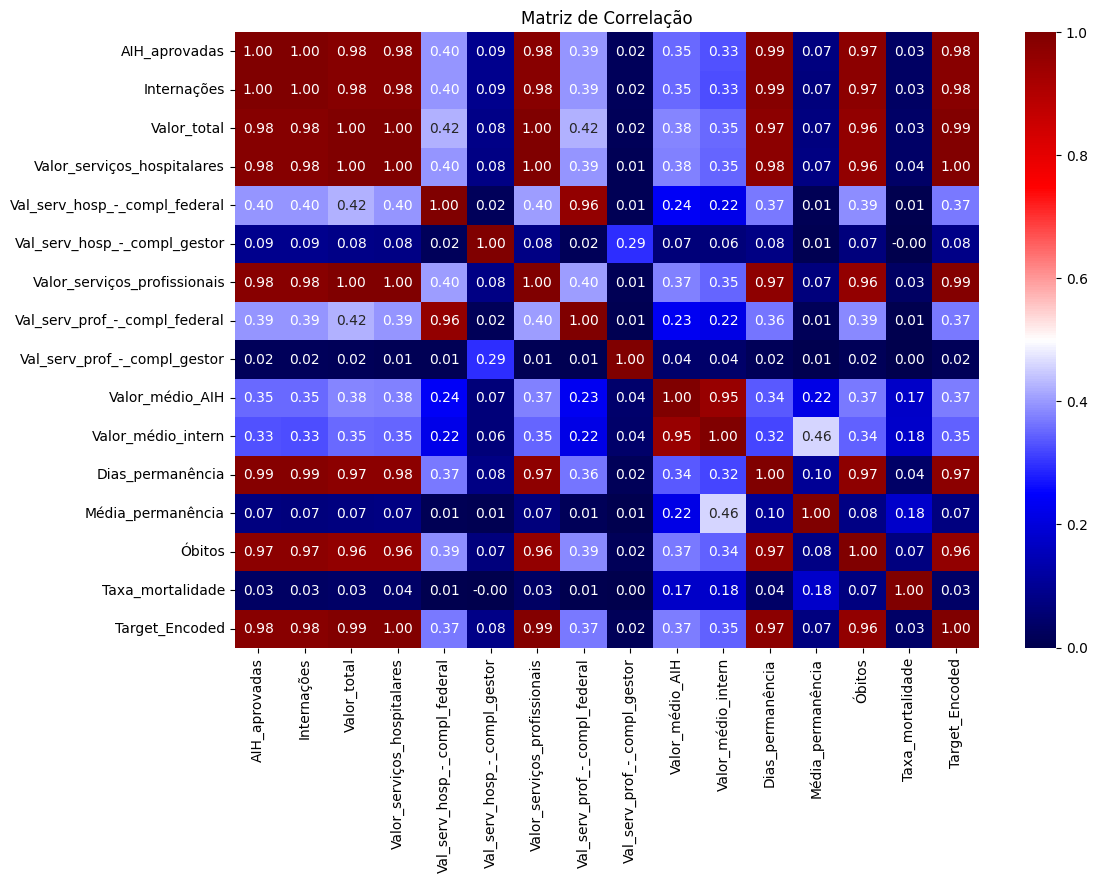

In [5]:
from category_encoders import TargetEncoder

df = dados_unificados.copy()
# 2. Target Encoding
target_enc = TargetEncoder(smoothing=0)
df['Target_Encoded'] = target_enc.fit_transform(
    df['Município'], df['Valor_total'])

df = df.drop(columns=['Ano','Mês'])
numeric_df = df.select_dtypes(include=[np.number])

# Calcular a matriz de correlação
corr_matrix = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='seismic', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

## **TREINAMENTO**

## **AVALIAÇÃO DO MODELO**